imports

In [13]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.special import kv
import scipy.special

In [14]:
#This is a PCCA implementation adapted from https://github.com/gwgundersen/ml/ by Gregory Gundersen

"""============================================================================
Probabilistic canonical correlation analysis. For references in comments:

    A Probabilistic Interpretation of Canonical Correlation Analysis.
    Bach, Jordan (2006).

    The EM algorithm for mixtures of factor analyzers.
    Ghahramani, Hinton (1996).
============================================================================"""

class PCCA:
    def __init__(self, components=2, iterations=100, regularization=1e-5):
        self.latent_dim = components
        self.max_iters = iterations
        self.eps = regularization

    def fit(self, X_a, X_b):
        """Fits the probabilistic CCA model."""
        num_samples = min(X_a.shape[0], X_b.shape[0])

        if X_a.shape[0] != X_b.shape[0]:
            X_a, X_b = X_a[:num_samples], X_b[:num_samples]

        self.dim_a, self.dim_b = X_a.shape[1], X_b.shape[1]
        self._initialize(X_a, X_b)

        for iteration in range(self.max_iters):
            self._update()

        self.noise_cov += self.eps * np.eye(self.noise_cov.shape[0])

    def _initialize(self, X_a, X_b):
        """Initializes model parameters."""
        self.total_dim = self.dim_a + self.dim_b

        # Compute mean vectors
        mean_a, mean_b = X_a.mean(axis=0), X_b.mean(axis=0)
        self.mean_vector = np.concatenate([mean_a, mean_b])

        # Compute empirical covariance
        stacked_data = np.hstack((X_a, X_b))
        covariance_matrix = np.cov(stacked_data.T, bias=True)

        # Initialize weight matrix
        self.weights = np.random.randn(self.total_dim, self.latent_dim)

        # Initialize noise covariance
        self.noise_cov = np.diag(np.diag(covariance_matrix))

    def _update(self):
        """Performs an EM-step update."""
        precision = np.linalg.pinv(self.noise_cov)

        transform_matrix = np.linalg.pinv(
            np.eye(self.latent_dim) + 0.01 * self.weights.T @ precision @ self.weights
        )

        self.weights = precision @ self.weights @ transform_matrix

        self.noise_cov = np.diag(np.maximum(np.diag(self.noise_cov), self.eps))

    def project(self, X_a, X_b):
        """Maps new data to latent space."""
        combined_X = np.hstack([X_a, X_b]).T
        precision = np.linalg.pinv(self.noise_cov)
        transform_matrix = np.linalg.pinv(np.eye(self.latent_dim) + self.weights.T @ precision @ self.weights)
        latent_repr = transform_matrix @ self.weights.T @ precision @ combined_X
        return latent_repr.T

    def fit_project(self, X_a, X_b):
        self.fit(X_a, X_b)
        return self.project(X_a, X_b)

    def generate(self, sample_count=100):
        """Generates new samples."""
        latent_samples = np.random.randn(sample_count, self.latent_dim)

        generated_X = latent_samples @ self.weights.T + self.mean_vector
        generated_X += np.random.normal(0, 0.1, generated_X.shape)

        return generated_X[:, :self.dim_a], generated_X[:, self.dim_a:]

generate data:

In [15]:
K1 = 503
K2 = 607
T = 257
t = np.linspace(0, 2, T)

#latent factors
d_s = 1
d_1 = 2
d_2 = 3


rho = 1.0
l = 2.0
nu = 0.1

def rbf_kernel(t1, t2, rho=1.0, l=2.0):
    return rho * np.exp(-0.5 * ((t1[:, np.newaxis] - t2[np.newaxis, :]) / l)**2)

def generate_gp_trajectories(t, n_trajectories, kernel_func, nu=0.1):
    K_tt = kernel_func(t, t)
    L = np.linalg.cholesky(K_tt + nu * np.eye(len(t)))
    trajectories = np.zeros((n_trajectories, len(t)))
    for k in range(n_trajectories):
        z = np.random.randn(len(t))
        trajectories[k] = L @ z
    return trajectories

Z_shared = generate_gp_trajectories(t, d_s, rbf_kernel).T
Z_1 = generate_gp_trajectories(t, d_1, rbf_kernel).T
Z_2 = generate_gp_trajectories(t, d_2, rbf_kernel).T

A_s1 = np.random.randn(K1, d_s)
A_s2 = np.random.randn(K2, d_s)
A_1 = np.random.randn(K1, d_1)
A_2 = np.random.randn(K2, d_2)

X1 = np.zeros((K1, T))
X2 = np.zeros((K2, T))

for i in range(K1):
    shared_contrib = A_s1[i:i+1, :] @ Z_shared.T
    indep_contrib = A_1[i:i+1, :] @ Z_1.T
    X1[i] = (shared_contrib + indep_contrib).flatten()

for i in range(K2):
    shared_contrib = A_s2[i:i+1, :] @ Z_shared.T
    indep_contrib = A_2[i:i+1, :] @ Z_2.T
    X2[i] = (shared_contrib + indep_contrib).flatten()

X1 += np.random.normal(0, np.sqrt(nu), X1.shape)
X2 += np.random.normal(0, np.sqrt(nu), X2.shape)

print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)

X1 shape: (503, 257)
X2 shape: (607, 257)


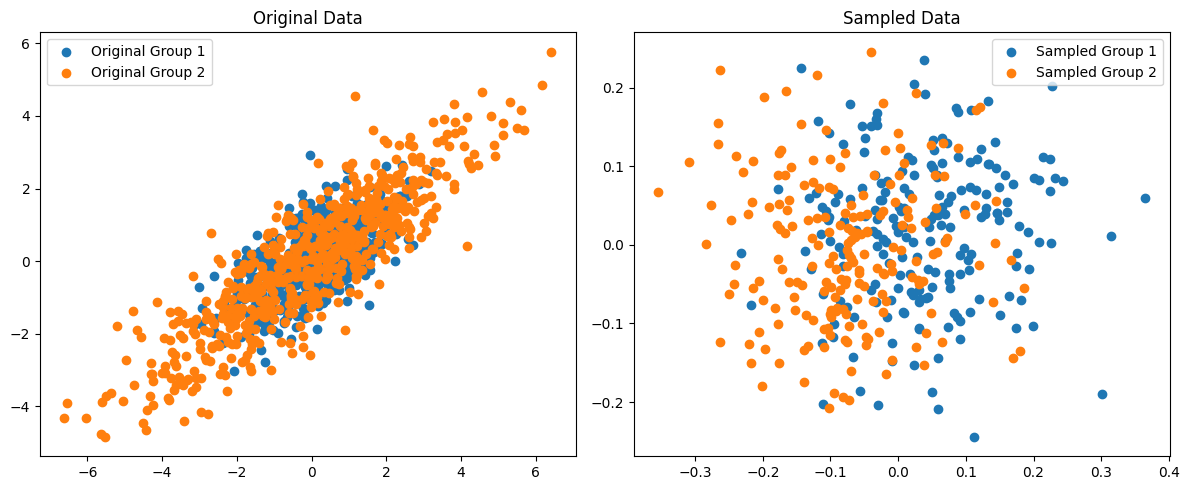

In [16]:
pcca = PCCA(components=2, iterations=100)
pcca.fit(X1, X2)
X1_, X2_ = pcca.generate(200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(X1[:, 0], X1[:, 1], label='Original Group 1')
ax1.scatter(X2[:, 0], X2[:, 1], label='Original Group 2')
ax1.set_title('Original Data')
ax1.legend()

ax2.scatter(X1_[:, 0], X1_[:, 1], label='Sampled Group 1')
ax2.scatter(X2_[:, 0], X2_[:, 1], label='Sampled Group 2')
ax2.set_title('Sampled Data')
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
# Basic Checks
print("\nBasic Checks:")
print("W matrix shape:", pcca.weights.shape)

# Calculate weights*weights_transposed for generated data
generated_weights = pcca.weights
generated_weights_transposed = generated_weights.T
generated_product = generated_weights @ generated_weights_transposed

# Calculate learned weights*learned_weights_transposed
learned_weights = pcca.weights  # Assuming pcca.W stores the learned weights.
learned_weights_transposed = learned_weights.T
learned_product = learned_weights @ learned_weights_transposed

# Compare the two products. We can't expect them to be exactly equal, due to randomness and the iterative nature of the algorithm. Instead, we check for closeness using an error metric such as the Frobenius norm.
difference = np.linalg.norm(generated_product - learned_product)
print("\nDifference between generated and learned weights products (Frobenius norm):", difference)

# Print the matrices for closer examination (optional, but helpful for debugging)
print("\nGenerated Weights Product:\n", generated_product)
print("\nLearned Weights Product:\n", learned_product)


Basic Checks:
W matrix shape: (514, 2)

Difference between generated and learned weights products (Frobenius norm): 0.0

Generated Weights Product:
 [[ 3.72571204e-217 -2.21039765e-204 -1.03444939e-180 ... -5.21154702e-161
  -3.04813947e-182 -3.55818617e-194]
 [-2.21039765e-204  1.31262172e-191  6.13998208e-168 ...  3.09310743e-148
   1.80940134e-169  2.11214352e-181]
 [-1.03444939e-180  6.13998208e-168  2.87279110e-144 ...  1.44726224e-124
   8.46544882e-146  9.88191830e-158]
 ...
 [-5.21154702e-161  3.09310743e-148  1.44726224e-124 ...  7.29109153e-105
   4.26471604e-126  4.97830814e-138]
 [-3.04813947e-182  1.80940134e-169  8.46544882e-146 ...  4.26471604e-126
   2.49459643e-147  2.91199764e-159]
 [-3.55818617e-194  2.11214352e-181  9.88191830e-158 ...  4.97830814e-138
   2.91199764e-159  3.39923984e-171]]

Learned Weights Product:
 [[ 3.72571204e-217 -2.21039765e-204 -1.03444939e-180 ... -5.21154702e-161
  -3.04813947e-182 -3.55818617e-194]
 [-2.21039765e-204  1.31262172e-191  6.1